In [88]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem

import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import pandas as pd
from gaussian import Gaussian

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [89]:
### get test r,p,ts geometries and model ts geometries
### then load d_init - how did he get d_init.npy?
### tests all len 842, model_ts_no_opt is 840

# base_folder = '/home/lagnajit/Dropbox (MIT)/Linux/PycharmProjects/dist2coords/log/v4/2layers_256hs_3its/'
base_folder = '../model_data/'
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
model_ts_no_opt_file = base_folder + 'model_ts.sdf'

test_ts = Chem.ForwardSDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]

test_r = Chem.ForwardSDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]

test_p = Chem.ForwardSDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

model_ts_no_opt = Chem.ForwardSDMolSupplier(model_ts_no_opt_file, removeHs=False, sanitize=False)
model_ts_no_opt = [x for x  in model_ts_no_opt]

In [90]:
# don't need their final D. just D_init, GT, LA

# their model D_init
D_init = np.load(base_folder + 'D_init.npy')

# all the other D_init runs
d_inits = []
file_base_folder = '../../log/'
D_init1 = np.load(file_base_folder + '21Jul03_1253PM/D_init.npy')
d_inits.append(D_init1)

In [91]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(len(d_inits))]

for idx in range(len(test_ts)):

    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for i, d_init_list in enumerate(d_init_lists):
        d_init_lists[i].append(np.ravel(d_inits[i][idx][0:num_atoms, 0:num_atoms]*core_mask))
    
# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]
all_ds = [ds[ds != 0] for ds in all_ds]
ds_dict = {'gt': (all_ds[0], 'Ground Truth Distribution'), 'best_init': (all_ds[1], 'Initial Model Distribution'),\
     'lin_approx': (all_ds[2], 'Linear Approximation Distribution')}
base_ds_counter = len(ds_dict)
for i in range(len(d_init_lists)):
    name = f'D_init{i+1}'
    ds_dict[name] = (all_ds[base_ds_counter + i], name)

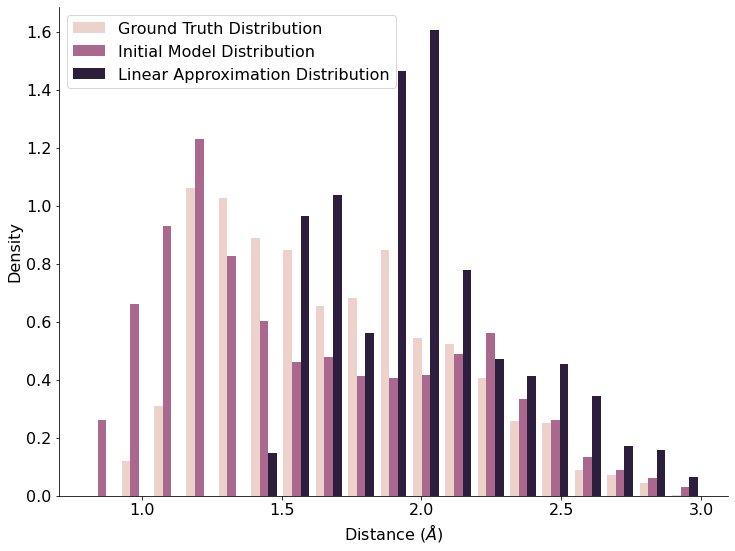

In [92]:
fig, ax = plt.subplots(figsize=(12,9))

# [[gt, best_init, ...], [GT Distr, Init Distr, ...]]

ds_to_plot = [ds_dict['gt'][0], ds_dict['best_init'][0], ds_dict['lin_approx'][0]]
labels = [ds_dict['gt'][1], ds_dict['best_init'][1], ds_dict['lin_approx'][1]]
num_cols = len(ds_to_plot)

bins = np.linspace(0.8, 3, 20)
ax.hist(ds_to_plot, bins, range=(0.8, 3), density=True, label=labels, color=sns.cubehelix_palette(num_cols))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   
#plt.savefig('dist_dists.png', bbox_inches='tight')

C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

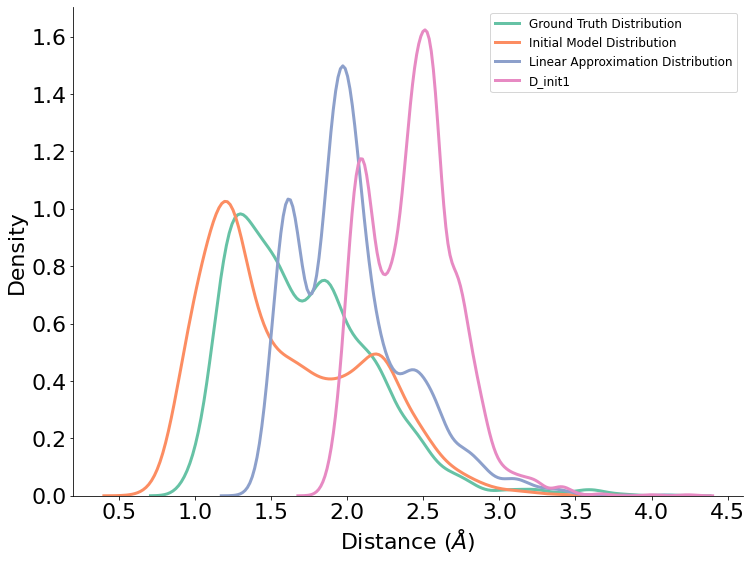

In [94]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

for i, key in enumerate(ds_dict.keys()):
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 